# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 8 : Mélange de lois

Dans ce chapitre, nous utiliserons le jeu de données *Galton.csv* disponible sur le site web du cours. Dans les années 1880, Francis Galton a recueilli des données sur la taille des enfants en fonction de la taille des parents. La description de ce jeu de donnée est fournie dans la cellule suivante. Nous n'utiliserons que le sexe et la taille des individus dans ce chapitre pour illustrer les concepts de ce chapitre.



<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd"><html xmlns="http://www.w3.org/1999/xhtml"><head><title>R: Galton's dataset of parent and child heights</title>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<link rel="stylesheet" type="text/css" href="R.css" />
</head><body>


<h2>Galton's dataset of parent and child heights</h2>

<h3>Description</h3>

<p>In the 1880's, Francis Galton was developing ways to quantify the
heritability of traits.  As part of this work, he collected data on
the heights of adult children and their parents.
</p>


<h3>Format</h3>

<p>A data frame with 898 observations on the following variables.
</p>

<ul>
<li><p><code>family</code> a factor with levels for each family
</p>
</li>
<li><p><code>father</code> the father's height (in inches)
</p>
</li>
<li><p><code>mother</code> the mother's height (in inches)
</p>
</li>
<li><p><code>sex</code> the child's sex: <code>F</code> or <code>M</code>
</p>
</li>
<li><p><code>height</code> the child's height as an adult (in inches)
</p>
</li>
<li><p><code>nkids</code> the number of adult children in the family, or, at least,
the number whose heights Galton recorded.
</p>
</li></ul>


<h3>Details</h3>

<p>Entries were deleted for
those children whose heights were not recorded numerically by Galton,
who sometimes used entries such as "tall", "short", "idiotic", "deformed" and so on.
</p>


<h3>Source</h3>

<p>The data were transcribed by J.A. Hanley who has published them at
<a href="http://www.medicine.mcgill.ca/epidemiology/hanley/galton/">http://www.medicine.mcgill.ca/epidemiology/hanley/galton/</a>
</p>


<h3>References</h3>

<p>&quot;Transmuting&quot; women into men: Galton's family data on human stature. (2004)
<em>The American Statistician</em>, 58(3):237-243.
</p>



</body></html>


In [1]:
# Chargement des librairies nécessaires
using CSV, DataFrames, Statistics, Gadfly, Distributions, Random, MLBase
# using Cairo, Fontconfig

## Fonctions utiles

In [2]:
"""
    GMM(ω::Real, μ₀::Real, σ₀::Real, μ₁::Real, σ₁::Real)

Création d'un objet de type `UnivariateMixture` de la librairie *Distributions.jl* ayant comme densité

```math
f(y) = (1-ω) ~ \\mathcal{N}( y\\mid μ₀, σ₀²) + ω ~ \\mathcal{N}( y\\mid μ₁, σ₁²)
```
"""
function GMM(ω::Real, μ₀::Real, σ₀::Real, μ₁::Real, σ₁::Real)
    
    pd = MixtureModel(Normal[ Normal(μ₀, σ₀), Normal(μ₁, σ₁)], [1-ω, ω])
    
    return pd
    
end


"""
    componentprob(mixturemodel::UnivariateMixture, y::Real; componentindex=1, logprob=false)

Calcul de la probabilité que y provienne de la composante `componentindex` du mélange `mixturemodel`.
"""
function componentprob(mixturemodel::UnivariateMixture, y::Real; componentindex=1, logprob=false)

    fc = component(mixturemodel,componentindex)
    
    lp = log(probs(mixturemodel)[componentindex]) + logpdf(fc,y) - logpdf(mixturemodel, y)
    
    if logprob
        return lp
    else
        return exp(lp)
    end
    
end

"""
    _emstep(pd::MixtureModel,y)

Réalisation d'une itération de l'algorithme EM à partir du mélange `pd` avec les données `y`.

#### Détails
La fonction met à jour les paramètres de la distribution `pd` avec les estimations améliorées.
"""
function _emstep(pd::MixtureModel,y)
    
    n = length(y)
    
    f₁ = component(pd, 2)
    ω = probs(pd)[2]
    
    lp₁ = log(ω) .+ logpdf.(f₁,y) - logpdf.(pd, y)
    p₁ = exp.(lp₁)
    
    ω̂ = sum(p₁)/n
    
    p₀ = 1 .- p₁
    
    μ̂₀ = sum( p₀.* y) / sum(p₀)
    
    σ̂₀² = sum( p₀.* (y .- μ̂₀).^2 ) / sum(p₀)
    
    μ̂₁ = sum( p₁.* y) / sum(p₁)
    
    σ̂₁² = sum( p₁.* (y .- μ̂₁).^2 ) / sum(p₁)
    
    fd = GMM(ω̂, μ̂₀, sqrt(σ̂₀²), μ̂₁, sqrt(σ̂₁²))
    
    return fd
    
end

"""
    GMMemfit(y::Vector{<:Real} ; initialvalue::Vector{<:Real}=Float64[], maxiter::Int=1000, tol::Real=2*eps())

Calcul des estimateurs du maximum de la vraisemblance d'un mélange de lois normales avec l'algorithme EM.
"""
function GMMemfit(y::Vector{<:Real} ; initialvalue::Vector{<:Real}=Float64[], maxiter::Int=1000, tol::Real=2*eps())
    
    if isempty(initialvalue)
        
        n = length(y)
        
        ind = (1:n) .< n/2
        
        y₀ = y[ind]
        y₁ = y[.!(ind)]
        
        initialvalue = [.5, mean(y₀), std(y₀), mean(y₁), std(y₁)]
        
    end
    
    pd = GMM(initialvalue...)
    
    iter = 1
    err = 1
    
    while (err > tol) & (iter < maxiter)
       
        fd = _emstep(pd,y)
        
        err = abs(loglikelihood(fd,y) - loglikelihood(pd,y))
        
        pd = fd
        
        iter +=1
        
    end
    
    μ₀ = mean(components(pd)[1])
    μ₁ = mean(components(pd)[2])

    if μ₀ > μ₁
        μ₀ = mean(components(pd)[2])
        σ₀ = std(components(fpd)[2])
        μ₁ = mean(components(pd)[1])
        σ₀ = std(components(pd)[1])
        ω = probs(pd)[1]

        pd = GMM(ω, μ₀, σ₀, μ₁, σ₁)

    end
    
    
    
    if iter == maxiter
        println("Convergence not reached in $maxiter iterations")
    else
        println("Convergence reached in $iter iterations")
    end
    
 return pd
    
end


GMMemfit

# Chargement des données

In [3]:
data = CSV.read("Galton.csv", DataFrame)
select!(data, [:sex, :height])
first(data,5)

,sex,height
,String1,Float64
1,M,73.2
2,F,69.2
3,F,69.0
4,F,69.0
5,M,73.5


# Analyse exploratoire

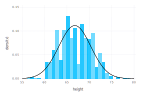

In [4]:
# Histogramme des données

n = size(data,1)

nbin = floor(Int,sqrt(n))

ȳ = mean(data.height)
s = std(data.height)

a = repeat([0.55, 0.85], outer=nbin)

fig = plot(Guide.ylabel("densité"),
        layer(x->pdf(Normal(ȳ,s),x),55,80, Geom.line, Theme(default_color="black")),
        layer(data, x=:height, alpha=[a;a], Geom.histogram(bincount = nbin, density=true))
        )

# draw(PDF("histogram.pdf"), fig)

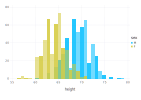

In [5]:
fig = plot(data, x=:height, color=:sex, alpha=[a;a], Geom.histogram(position=:identity, bincount = nbin))

# draw(PDF("mixture_histogram.pdf"), fig)ù

# 8.1 Mélange de lois

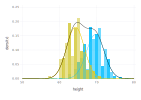

In [6]:
ω̂, μ̂₀, σ̂₀, μ̂₁, σ̂₁ = (0.4648, 64.28, 2.37, 69.62, 2.41) 

fd = GMM(ω̂, μ̂₀, σ̂₀, μ̂₁, σ̂₁)
f₁ = component(fd,1)
f₂ = component(fd,2)

fig = plot(Guide.ylabel("densité"),
        layer(x -> 2*pdf(fd, x), 50, 80, Theme(default_color="black")),
        layer(x -> 2*(1-ω̂)*pdf(f₁, x), 50, 80, Geom.line, Theme(default_color="gold2")),
        layer(x -> 2*ω̂*pdf(f₂, x), 50, 80),
        layer(data, x=:height, color=:sex, alpha=[a;a], Geom.histogram(position=:identity, bincount = nbin, density=true)),
    )
# # draw(PDF("mixture_histogram.pdf"), fig)

#  On multiplie par 2 les densités car Gadfly a produit deux histogrammes normalisés pour chacune des classes. 
# Alors l'aire sous les deux histogrammes est de 2.

# 8.2 Variable manquante 

In [ ]:
yx = collect(55:.1:80)
p = componentprob.(fd, yx , componentindex=2)

df = DataFrame(height = yx, probabilité = p)

plot(df, x=:height, y=:probabilité, Geom.line)

In [ ]:
df_M = DataFrame(height=yx, y = ω̂*pdf.(Normal(μ̂₁,σ̂₁),yx), sex="M") 
df_F = DataFrame(height=yx, y = (1-ω̂)*pdf.(Normal(μ̂₀,σ̂₀),yx), sex="F") 
df = vcat(df_M, df_F)

fig = plot(df, x = :height, y=:y, color = :sex, Geom.line, Guide.ylabel("densité"),
        xintercept=[67.096], Geom.vline(color="red", style=:dash)
        )

# draw(PDF("calssification.pdf"), fig)



# 8.3 Estimation Bayésienne

In [ ]:
y = data.height
n = length(y)

### Spécification des lois *a priori* informatives

In [ ]:
ν₀ = 65.0
α₀ = 2
β₀ = 6

ν₁ = 65.0
α₁ = 2
β₁ = 6

α = 1
β = 1

### Implémentatation de l'échantillonnage de Gibbs

In [ ]:
Random.seed!(3302)

niter = 10000

ω = Vector{Float64}(undef,niter)
μ₀ = Vector{Float64}(undef,niter)
σ₀ = Vector{Float64}(undef,niter)
μ₁ = Vector{Float64}(undef,niter)
σ₁ = Vector{Float64}(undef,niter)

z = falses(n,niter)

ω[1] = .5
μ₀[1] = 60
σ₀[1] = 1
μ₁[1] = 70
σ₁[1] = 1

u = rand(n)

for iter in 2:niter
   
   pd = GMM(ω[iter-1], μ₀[iter-1], σ₀[iter-1], μ₁[iter-1], σ₁[iter-1]) 
    
   lp = componentprob.(pd, y, componentindex=2, logprob=true)
    
    rand!(u)
    
    z[:,iter] = lp .> log.(u)

    n₁ = count(z[:,iter])
    n₀ = n - n₁   
    
    if n₀ > 0   
        y₀ = y[.!(z[:,iter])]
        ȳ₀ = mean(y₀)
        
        pd = Normal( (n₀*ȳ₀ + ν₀)/(n₀+1), σ₀[iter-1]/sqrt((n₀+1)) )
        μ₀[iter] = rand(pd)

        b = (μ₀[iter]-ν₀).^2 + sum( (y₀ .- μ₀[iter]).^2 )
        pd = InverseGamma(α₀ + (n₀+1)/2, β₀ + b/2)
        σ₀[iter] = sqrt(rand(pd))
        
    else
        
        pd = Normal( ν₀, σ₀[iter-1])
        μ₀[iter] = rand(pd)
            
        pd = InverseGamma(α₀ +1/2, β₀ + .5*(μ₀[iter]-ν₀).^2)
        σ₀[iter] = sqrt(rand(pd))
            
    end
        
    
    if n₁ > 0   
        y₁ = y[z[:,iter]]
        ȳ₁ = mean(y₁)
            
        pd = Normal( (n₁*ȳ₁ + ν₁)/(n₁+1), σ₁[iter-1]/sqrt((n₁+1)) )
        μ₁[iter] = rand(pd)

        b = (μ₁[iter]-ν₁).^2 + sum( (y₁ .- μ₁[iter]).^2 )
        pd = InverseGamma(α₁ + (n₁+1)/2, β₁ + b/2)
        σ₁[iter] = sqrt(rand(pd))
    else
        
        pd = Normal( ν₁, σ₁[iter-1] )
        μ₁[iter] = rand(pd)
            
        pd = InverseGamma(α₁ + (n₁+1)/2, β₁ + .5*(μ₁[iter]-ν₁).^2)
        σ₁[iter] = sqrt(rand(pd))
        
    end
    
    ω[iter] = rand(Beta(α + n₁, β + n₀))
    
end


### Traçage de la chaîne générée

In [ ]:
mcmc = DataFrame(iteration = 1:niter, μ₀ = μ₀, σ₀ = σ₀, μ₁ = μ₁, σ₁ = σ₁, ω = ω)

fig = plot(mcmc, Guide.colorkey(title=""), Guide.ylabel(""),
        layer( x=:iteration, y=:μ₁, Geom.line, color=["μ₁"]),
        layer( x=:iteration, y=:μ₀, Geom.line, color=["μ₀"])        
    )

# draw(PDF("trace_mu.pdf"), fig)

In [ ]:
plot(mcmc, Guide.colorkey(title=""), Guide.ylabel(""),
    layer( x=:iteration, y=:σ₀, Geom.line, color=["σ₀"]),
    layer( x=:iteration, y=:σ₁, Geom.line, color=["σ₁"])
)

In [ ]:
plot(mcmc, x=:iteration, y=:ω, Geom.line)

### Classification obtenue à partir de la chaîne générée

In [ ]:
# Calcul de la probabilité que les observations proviennent de la deuxième composante
p̂ = dropdims(mean(z,dims=2), dims=2)

In [ ]:
# Classification estimée
Ẑ = p̂ .> .5
Z = data.sex .== "M"

In [ ]:
r = roc(Z, Ẑ)

In [ ]:
confusionMatrix = DataFrame(Prédiction = Int64[], Réalité = Int64[], Nombre = Int64[] )
push!(confusionMatrix, [0,0,r.tn])
push!(confusionMatrix, [0,1,r.fn])
push!(confusionMatrix, [1,0,r.fp])
push!(confusionMatrix, [1,1,r.tp])
plot(confusionMatrix, x=:Prédiction, y=:Réalité, color = :Nombre, Geom.rectbin, 
    Scale.color_continuous(colormap=Scale.lab_gradient("white", "blue")))

In [ ]:
println("Proportion des hommes bien identifiés = $(recall(r))")
println("Proportion des femmes bien identifiées = $(true_negative_rate(r))")

# 8.4 Estimation par maximum de la vraisemblance 

En utilisant l'algorithme EM, on peut faire 50 améliorations aen utilisant la fonction `_emstep()` fournie.

In [ ]:
# Valeurs initiales des paramètres
ω = .5
μ₀ = 50
σ₀ = 3
μ₁ = 80
σ₁ = 3

y = data[:, :height]

pd = GMM(ω,μ₀,σ₀,μ₁,σ₁)

df = DataFrame(Itération = Int64[], ω = Float64[], μ₀ = Float64[], σ₀ = Float64[], μ₁ = Float64[], σ₁ = Float64[])

push!(df, [1, ω, μ₀, σ₀, μ₁, σ₁])

for i=2:50
    pd = _emstep(pd,y)
    
    ω = probs(pd)[2]
    μ₀ = mean(component(pd, 1))
    σ₀ = std(component(pd, 1))
    μ₁ = mean(component(pd, 2))
    σ₁ = std(component(pd, 2))
    
    push!(df, [i, ω, μ₀, σ₀, μ₁, σ₁])
end



In [ ]:
fig1 = plot(df, x=:Itération, y=:ω, Geom.line)
fig2 = plot(df, x=:Itération, y=:μ₀, Geom.line)
fig3 = plot(df, x=:Itération, y=:σ₀, Geom.line)
fig4 = plot(df, x=:Itération, y=:μ₁, Geom.line)
fig5 = plot(df, x=:Itération, y=:σ₁, Geom.line)

set_default_plot_size(21cm, 16cm)
gridstack([fig1 fig2 fig3; plot() fig4 fig5])

### Laissons pousuivre l'algorithme EM jusqu'à convergence

On peut utiliser la fonction `GMMemfit()` fournie.

In [ ]:
fd = GMMemfit(y, initialvalue=[ω, μ₀, σ₀, μ₁, σ₁])

In [ ]:
f₀ = component(fd, 1)
f₁ = component(fd, 2)
ω̂ = probs(fd)[2]

# Permutation si μ₀ > μ₁
if mean(f₀)>mean(f₁)
    f₁ = component(fd, 1)
    f₀ = component(fd, 2)
    ω̂ = probs(fd)[1]
    
    fd = GMM(ω,mean(f₁),std(f₁),mean(f₂),std(f₂))
end    

x = 55:.01:80

df = DataFrame(Height = x, f₁ = probs(fd)[2]*pdf.(f₁,x), f = pdf.(fd,x), f₀ = probs(fd)[1]*pdf.(f₀,x))

df = stack(df, Not(:Height))
rename!(df, :variable => :Composante, :value => :Density)

set_default_plot_size(14cm, 8cm)
plot(df, x=:Height, y=:Density, color=:Composante, Geom.line)

### Classification obtenue à partir de la chaîne générée

In [ ]:
# Calcul de la probabilité que les observations proviennent de la deuxième composante
p̂ = componentprob.(fd, y, componentindex=2)

In [ ]:
# Classification estimée
Ẑ = p̂ .> .5
Z = data.sex .== "M"

In [ ]:
r = roc(Z, Ẑ)

In [ ]:
confusionMatrix = DataFrame(Prédiction = Int64[], Réalité = Int64[], Nombre = Int64[] )
push!(confusionMatrix, [0,0,r.tn])
push!(confusionMatrix, [0,1,r.fn])
push!(confusionMatrix, [1,0,r.fp])
push!(confusionMatrix, [1,1,r.tp])
plot(confusionMatrix, x=:Prédiction, y=:Réalité, color = :Nombre, Geom.rectbin, 
    Scale.color_continuous(colormap=Scale.lab_gradient("white", "blue")))

In [ ]:
println("Proportion des hommes bien identifiés = $(recall(r))")
println("Proportion des femmes bien identifiées = $(true_negative_rate(r))")